In [2]:
import os
import sys
# from parent directory imports
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import copy
import pickle
import numpy as np
from tqdm import tqdm
from itertools import product

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer

import hamiltorch
from laplace import Laplace
from torch_sgld.sgld import SGLD
from torch_sgld.lr_scheduler import CosineLR, ABAnnealingLR

from sklearn import datasets

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
sns.set()

from source.utils.seeding import fix_seeds

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [3]:
os.makedirs("results_two_moon", exist_ok=True)

In [4]:
global_seed = 42

## Two Moon Dataset

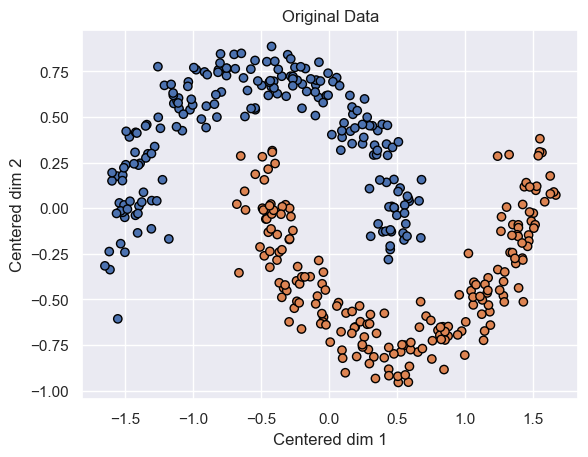

In [5]:
x_train, y_train = datasets.make_moons(n_samples=400, noise=0.1, random_state=global_seed)

# de-bias two moons
x_train -= np.asarray([0.5, 0.25])

n_classes = 2

x_labels= ["dim 1", "dim 2"]

plt.title("Original Data")
plt.scatter(x_train[:, 0], x_train[:, 1], c=[f"C{y}" for y in y_train], edgecolors="black")
plt.xlabel("Centered " + x_labels[0])
plt.ylabel("Centered " + x_labels[1])
plt.show()

num_mesh = 80
x_slack = (np.max(x_train[:, 0]) - np.min(x_train[:, 0])) * 0.45
y_slack = (np.max(x_train[:, 1]) - np.min(x_train[:, 1])) * 0.45
x_test = np.asarray(np.meshgrid(np.linspace(np.min(x_train[:, 0]) - x_slack, np.max(x_train[:, 0]) + x_slack, num_mesh),
                                np.linspace(np.min(x_train[:, 1]) - y_slack, np.max(x_train[:, 1]) + y_slack, num_mesh)))
x_test = np.moveaxis(x_test, 0, -1).reshape(-1, 2)

### Helper Functions



In [6]:
def fit(network, opt, X, y, iterations, batch_size, plot=True):
    losses = list()
    ce = nn.CrossEntropyLoss()

    for _ in tqdm(range(iterations)):
        idx = torch.randperm(X.size(0))[:batch_size]
        pred = network.forward(X[idx])

        loss = ce(pred, y[idx])

        losses.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

    if plot:
        plt.plot(losses, label="train loss")
        plt.yscale("log")
        plt.ylim(1e-4, 1e1)
        plt.hlines(y=-np.log(1/pred.shape[-1]), xmin=0, xmax=iterations, colors="red")
        plt.hlines(y=-np.log(0.5), xmin=0, xmax=iterations, colors="green")
        plt.hlines(y=-np.log((pred.shape[-1] - 1)/pred.shape[-1]), xmin=0, xmax=iterations, colors="green", linestyle="dotted")
        plt.hlines(y=-np.log(0.9), xmin=0, xmax=iterations, colors="green", linestyle="dashed")
        plt.legend()
        plt.show()

    return network


def visualize(pred_test, X, y, X_test, title, filename=None):
    try:
        X = X.cpu().numpy()
    except:
        pass
    try:
        y = y.cpu().numpy()
    except:
        pass
    try:
        X_test = X_test.cpu().numpy()
    except:
        pass
    try:
        pred_test = pred_test.cpu().numpy()
    except:
        pass

    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(title, fontsize=20)
    axs[0, 0].set_title("Max Prediction", fontsize=16)
    cf = axs[0, 0].contourf(X_test[:, 0].reshape(num_mesh, num_mesh), X_test[:, 1].reshape(num_mesh, num_mesh),
                            np.max(np.mean(pred_test, axis=0), axis=1).reshape(num_mesh, num_mesh), cmap="Greys",
                            alpha=1,
                            levels=np.linspace(0, 1, 101))
    fig.colorbar(cf, ax=axs[0, 0])
    axs[0, 0].scatter(X[:, 0], X[:, 1], c=[f"C{_y}" for _y in y], edgecolors="black")
    axs[0, 0].set_xlabel("Centered " + x_labels[0])
    axs[0, 0].set_ylabel("Centered " + x_labels[1])

    cmaps = ["Blues", "Oranges", "Greens"]
    for i in range(n_classes):
        ax = axs[(i + 1) // 2, (i + 1) % 2]
        ax.set_title(f"Predictions for Class {i}", color=f"C{i}", fontsize=16)
        cf = ax.contourf(X_test[:, 0].reshape(num_mesh, num_mesh), X_test[:, 1].reshape(num_mesh, num_mesh),
                         np.mean(pred_test, axis=0)[:, i].reshape(num_mesh, num_mesh), cmap=cmaps[i], alpha=1,
                         levels=np.linspace(0, 1, 101))
        fig.colorbar(cf, ax=ax)
        ax.scatter(X[:, 0], X[:, 1], c=[f"C{_y}" for _y in y], edgecolors="black")
        ax.set_xlabel("Centered " + x_labels[0])
        ax.set_ylabel("Centered " + x_labels[1])
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join("results_two_moon", filename))
    plt.show()

def plot_uncertainty(yy, x, x_test, uncertainties, minmaxes, titles, filename, log=False):
    n_rows, n_cols = 2, 3
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 8))


    print(axs.shape)
    
    for i in range(n_rows):
        for j in range(n_cols):
            axs[i, j].set_title(titles[i * n_cols + j], fontsize="x-large")
            cf = axs[i, j].contourf(x_test[:, 0].reshape(num_mesh, num_mesh), x_test[:, 1].reshape(num_mesh, num_mesh),
                        uncertainties[i * n_cols + j].reshape(num_mesh, num_mesh), 
                        cmap="viridis", alpha=1,
                        locator=ticker.LogLocator() if log else ticker.MaxNLocator(),
                        levels=np.logspace(minmaxes[i * n_cols + j][0], minmaxes[i * n_cols + j][1], 101),
                        extend="both")
            axs[i, j].scatter(x[:, 0], x[:, 1], c=[f"C{int(_y)}" for _y in yy], edgecolors="black")
            fig.colorbar(cf, ax=axs[i, j])
            axs[i, j].set_xlabel("Centered " + x_labels[0])
            axs[i, j].set_ylabel("Centered " + x_labels[1])
    plt.tight_layout()
    plt.savefig(os.path.join("results_two_moon", filename + ".pdf"))
    plt.savefig(os.path.join("results_two_moon", filename + ".png"))
    plt.show()

from matplotlib.ticker import FormatStrFormatter

def plot_single_uncertainty(yy, x, x_test, uncertainty, minmax, filename, log=True, ref_pred = None):

    plt.figure(figsize=(6, 4.5))

    uncertainty = np.maximum(uncertainty, 1e-8)

    plt.contourf(x_test[:, 0].reshape(num_mesh, num_mesh), x_test[:, 1].reshape(num_mesh, num_mesh),
        uncertainty.reshape(num_mesh, num_mesh), 
        cmap="viridis", alpha=1,
        locator=ticker.LogLocator() if log else ticker.MaxNLocator(),
        levels=np.logspace(minmax[0], minmax[1], 101),# if log else np.linspace(minmax[0], minmax[1], 101),
        extend="both")
    if ref_pred is not None:
        plt.contour(x_test[:, 0].reshape(num_mesh, num_mesh), x_test[:, 1].reshape(num_mesh, num_mesh),
                ref_pred[:, 0].reshape(num_mesh, num_mesh), levels=[0.5])
    #plt.colorbar(format=FormatStrFormatter("%.2f"))
    plt.scatter(x[:, 0], x[:, 1], c=[f"C{int(_y)}" for _y in yy], edgecolors="black")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(os.path.join("results_two_moon", filename + ".png"))
    plt.show()

## General Parameters

In [7]:
lr = 1e-3
hidden_size = 100
weight_decay = 1e-3
batch_size = 32
iterations = 1000

## Reference Model
except for MC dropout

100%|██████████| 1000/1000 [00:03<00:00, 291.00it/s]


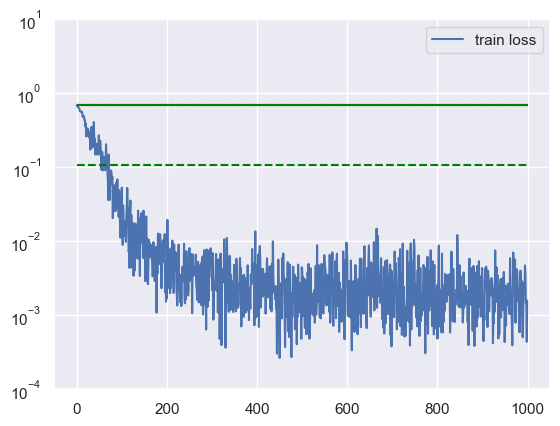

In [8]:
fix_seeds(global_seed)

x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.long).flatten()
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32)

network = nn.Sequential(nn.Linear(2, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, n_classes))

network.to(device)
network.train()

opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

fit(network, opt, x_train, y_train, iterations, batch_size)

with torch.no_grad():
    reference_pred = torch.softmax(network.forward(x_test), dim=1).detach().cpu().numpy()

## HMC

In [9]:
# parameters
step_size = 0.001
num_samples = 10_000
burn = 200
L = 1_000
mass = 1e-0

In [10]:
fix_seeds(global_seed)
hamiltorch.set_random_seed(global_seed)

network = nn.Sequential(nn.Linear(2, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, n_classes))

network.to(device)
network.train()

params_init = hamiltorch.util.flatten(network).to(device).clone()
print('Parameter size: ',params_init.shape[0])

Parameter size:  20702


In [11]:
tau_list = []
tau = 1.
for w in network.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [49]:
x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.float32).reshape(-1, 1)
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32)
y_test = torch.ones((len(x_test), 1)).to(device=device, dtype=torch.float32)

In [ ]:
inv_mass = torch.ones(params_init.shape, device=device) / mass
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC

params_hmc = hamiltorch.sample_model(network, x_train, y_train, model_loss='multi_class_linear_output', integrator=integrator, sampler=sampler, 
                                     params_init=params_init, num_samples=num_samples, burn=burn, step_size=step_size, num_steps_per_sample=L, tau_list=tau_list)

In [75]:
pred_list, log_prob_list = hamiltorch.predict_model(network, x=x_test, y=y_test, model_loss='multi_class_linear_output', samples=params_hmc[:], tau_list=tau_list)

print(tau_list[0])
print('\nExpected validation log probability: {:.2f}'.format(torch.stack(log_prob_list).mean()))

tensor(1., device='cuda:0')

Expected validation log probability: -1517964.62


In [ ]:
with open(os.path.join("results_two_moon", "preds_hmc.pkl"),"wb") as f:
    pickle.dump(pred_list, f)

In [47]:
with open(os.path.join("results_two_moon", "preds_hmc.pkl"),"rb") as f:
    pred_list = pickle.load(f)

In [50]:
yy = y_train.cpu().to(torch.long).numpy()
x = x_train.cpu().numpy()
x_test = x_test.cpu().numpy()
pred_list = torch.softmax(pred_list, dim=2)
pred_list = pred_list.cpu().numpy()

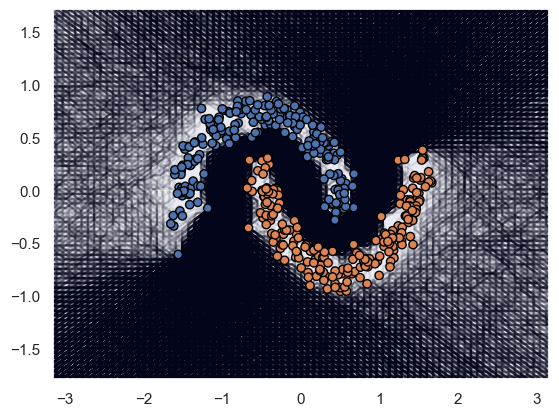

In [16]:
for pred in pred_list[:-1]:
    plt.contour(x_test[:, 0].reshape(num_mesh, num_mesh), x_test[:, 1].reshape(num_mesh, num_mesh),
                pred[:, 0].reshape(num_mesh, num_mesh), alpha=0.1, levels=[0.5])
plt.scatter(x[:, 0], x[:, 1], c=[f"C{int(_y)}" for _y in yy], edgecolors="black", zorder=99)
plt.show()

In [17]:
print(pred_list.shape, reference_pred.shape)

(9800, 6400, 2) (6400, 2)


(2, 3)


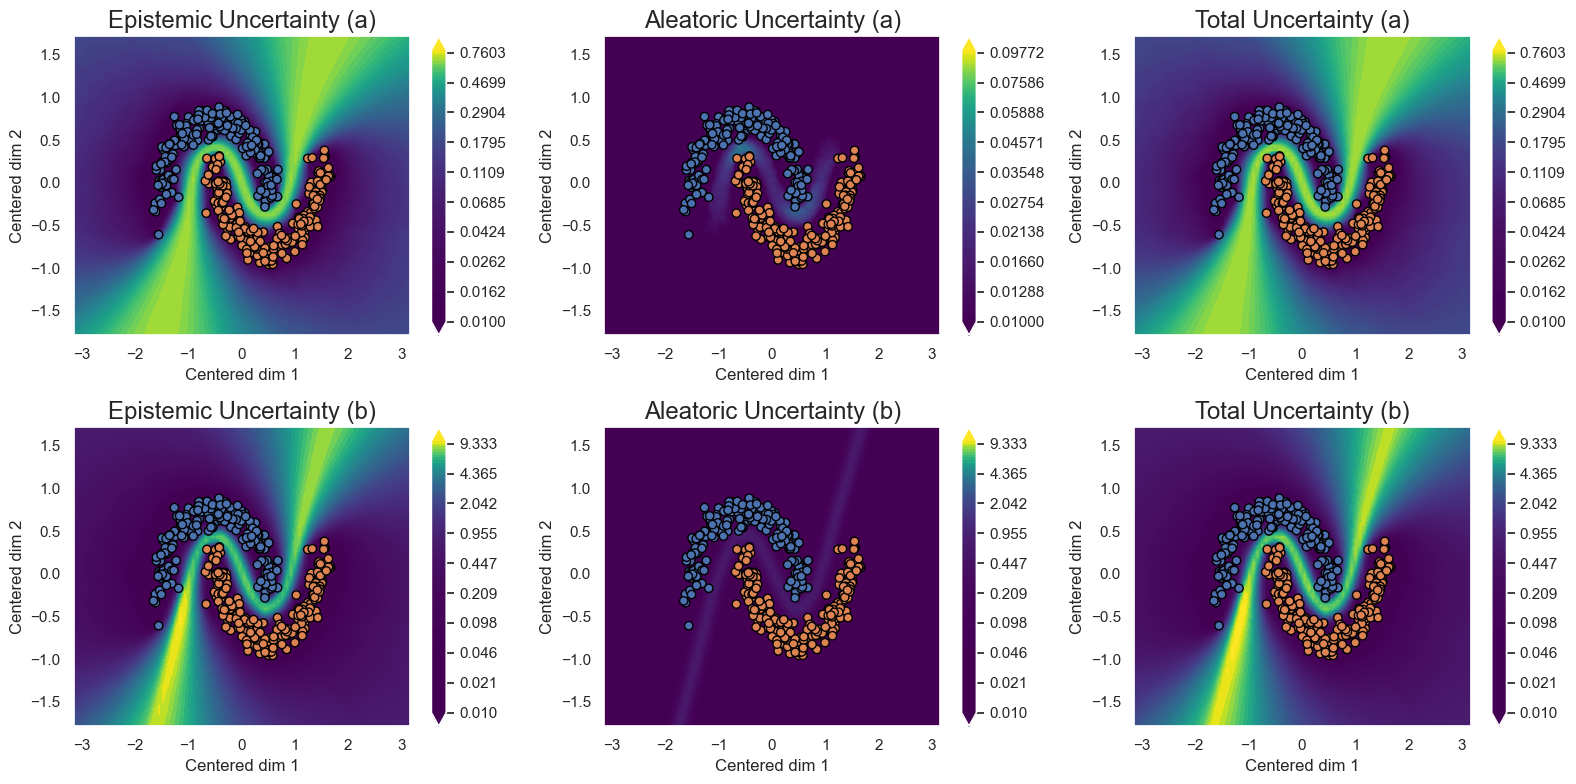

In [51]:
total_a = - np.sum(np.mean(pred_list, axis=0) * np.log(np.mean(pred_list, axis=0) + 1e-8), axis=-1)
aleatoric_a = np.mean( - np.sum(pred_list * np.log(pred_list + 1e-8), axis=-1), axis=0)
epistemic_a = total_a - aleatoric_a

total_b = - np.mean(np.sum(reference_pred[np.newaxis] * np.log(pred_list + 1e-8), axis=-1), axis=0)
aleatoric_b = - np.sum(reference_pred * np.log(reference_pred + 1e-8), axis=-1)
epistemic_b = total_b - aleatoric_b

uncertainties = [epistemic_a, aleatoric_a, total_a, epistemic_b, aleatoric_b, total_b]
titles = ["Epistemic Uncertainty (a)", "Aleatoric Uncertainty (a)", "Total Uncertainty (a)", "Epistemic Uncertainty (b)", "Aleatoric Uncertainty (b)", "Total Uncertainty (b)"]
minmaxes = [(-2, -0.1), (-2, -1), (-2, -0.1), (-2, 1), (-2, 1), (-2, 1)]

plot_uncertainty(yy, x, x_test, uncertainties, minmaxes, titles, "class_hmc_uncertainty")

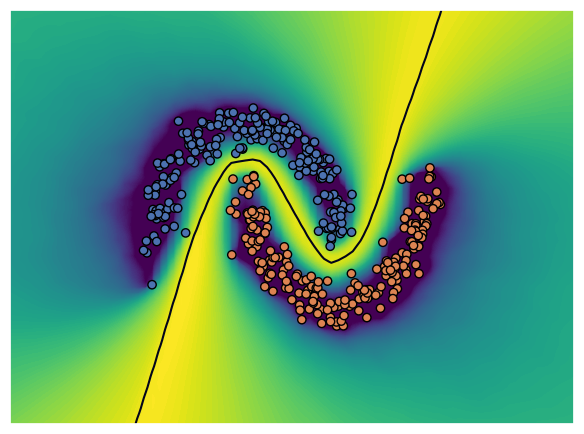

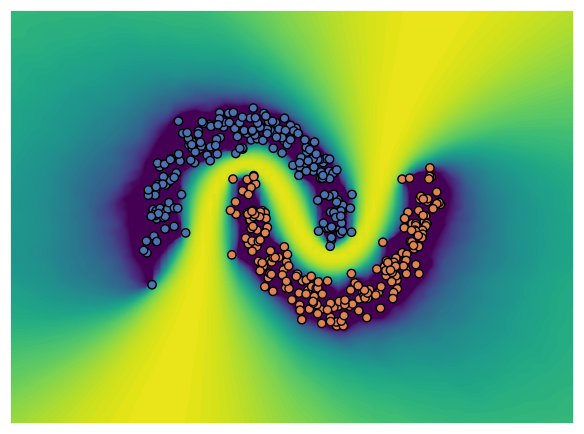

In [19]:
plot_single_uncertainty(yy, x, x_test, epistemic_b, (-2, 1), "hmc_setting_b_epistemic_uncertainty", log=True, ref_pred=reference_pred)
plot_single_uncertainty(yy, x, x_test, epistemic_a, (-2, -0.1), "hmc_setting_a_epistemic_uncertainty", log=True)

## Laplace

In [20]:
# parameters
subset_of_weights = "last_layer" # all, last_layer, subnetwork
hessian_structure = "kron" # full, kron, diag, lowrank (only with all)
link_approx = "mc" # mc, probit, bridge

h_epochs = 5_000

n_samples = 5_000

100%|██████████| 1000/1000 [00:03<00:00, 332.66it/s]


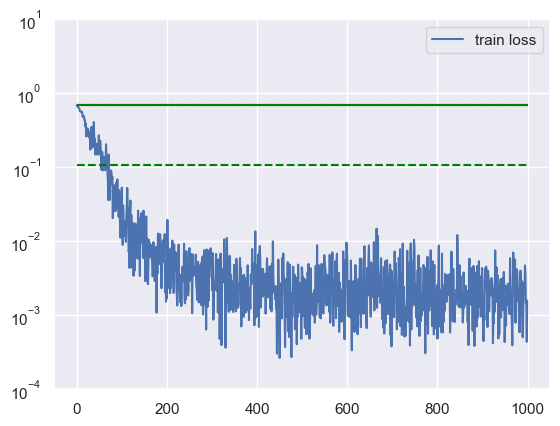

In [21]:
fix_seeds(global_seed)

x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.long).flatten()
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32)

laplace_hidden_size = hidden_size

network = nn.Sequential(nn.Linear(len(x_labels), laplace_hidden_size),
                        nn.ReLU(),
                        nn.Linear(laplace_hidden_size, laplace_hidden_size),
                        nn.ReLU(),
                        nn.Linear(laplace_hidden_size, laplace_hidden_size),
                        nn.ReLU(),
                        nn.Linear(laplace_hidden_size, n_classes))

network.to(device)
network.train()

opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

network = fit(network, opt, x_train, y_train, iterations, batch_size, plot=True)

In [22]:
la = Laplace(network, 'classification',
             subset_of_weights=subset_of_weights,
             hessian_structure=hessian_structure,
             prior_precision=weight_decay)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), 
        batch_size=batch_size
    )
la.fit(train_loader)

In [23]:
log_prior = torch.ones(1, requires_grad=True)
hyper_optimizer = optim.Adam([log_prior], lr=lr)

for i in tqdm(range(h_epochs)):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

100%|██████████| 5000/5000 [00:12<00:00, 394.18it/s]


In [24]:
pred_list = la.predictive_samples(x_test, pred_type='glm', n_samples=n_samples)

#pred_list = la(x_test, link_approx=link_approx, n_samples=n_samples)
print(pred_list.shape)

torch.Size([5000, 6400, 2])


In [25]:
yy = y_train.cpu().numpy()
x = x_train.cpu().numpy()
x_test = x_test.cpu().numpy()
pred_list = pred_list.cpu().numpy()

(2, 3)


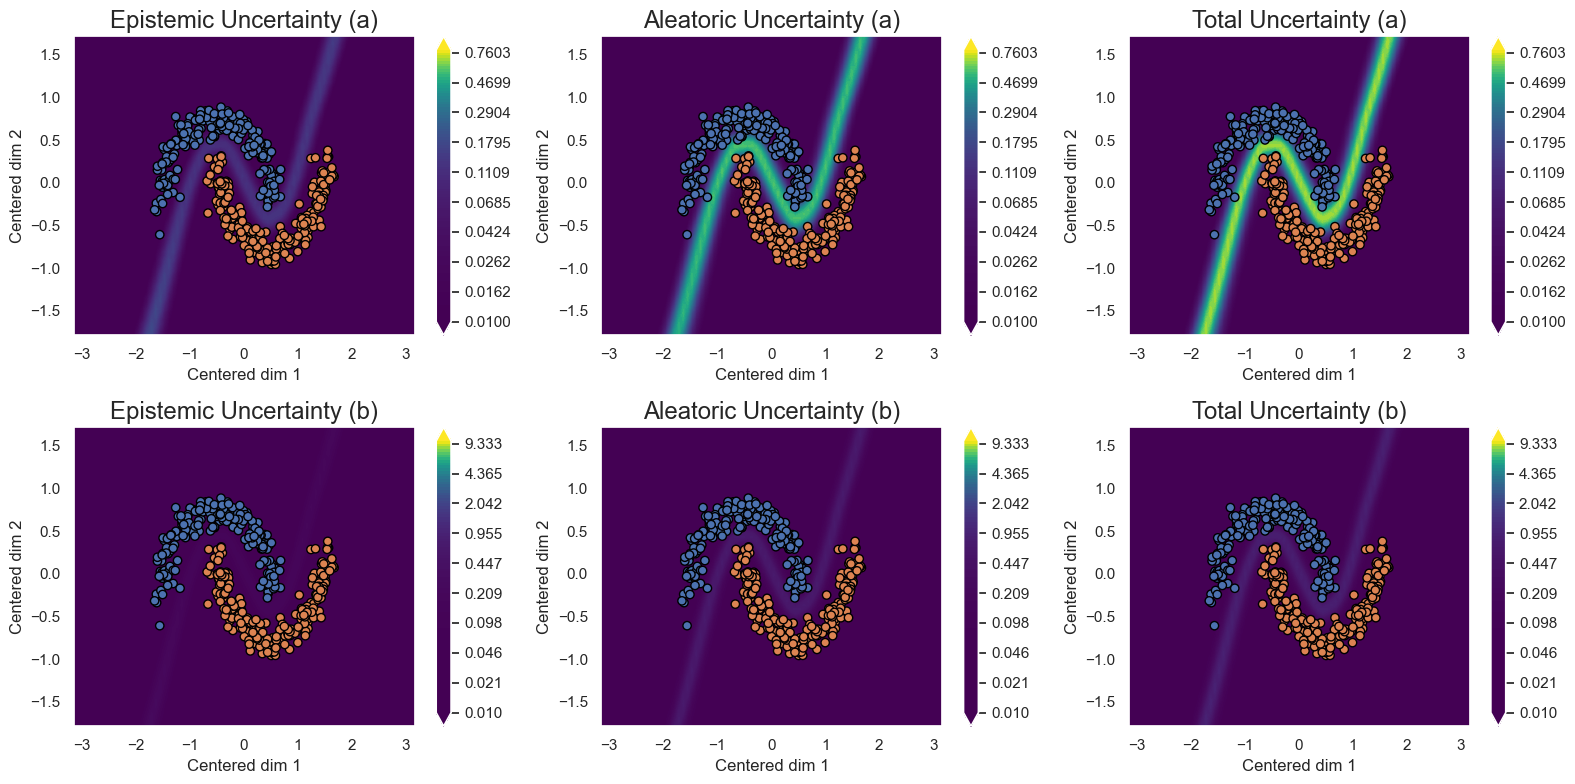

In [26]:
total_a = - np.sum(np.mean(pred_list, axis=0) * np.log(np.mean(pred_list, axis=0) + 1e-8), axis=-1)
aleatoric_a = np.mean( - np.sum(pred_list * np.log(pred_list + 1e-8), axis=-1), axis=0)
epistemic_a = total_a - aleatoric_a

total_b = - np.mean(np.sum(reference_pred[np.newaxis] * np.log(pred_list + 1e-8), axis=-1), axis=0)
aleatoric_b = - np.sum(reference_pred * np.log(reference_pred + 1e-8), axis=-1)
epistemic_b = total_b - aleatoric_b

uncertainties = [epistemic_a, aleatoric_a, total_a, epistemic_b, aleatoric_b, total_b]
titles = ["Epistemic Uncertainty (a)", "Aleatoric Uncertainty (a)", "Total Uncertainty (a)", "Epistemic Uncertainty (b)", "Aleatoric Uncertainty (b)", "Total Uncertainty (b)"]
minmaxes = [(-2, -0.1), (-2, -0.1), (-2, -0.1), (-2, 1), (-2, 1), (-2, 1)]

plot_uncertainty(yy, x, x_test, uncertainties, minmaxes, titles, "class_laplace_uncertainty")

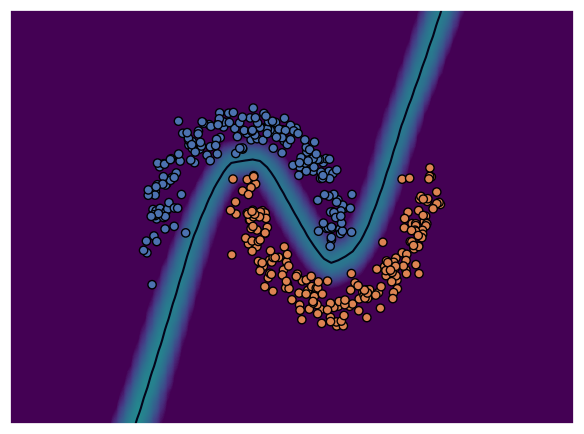

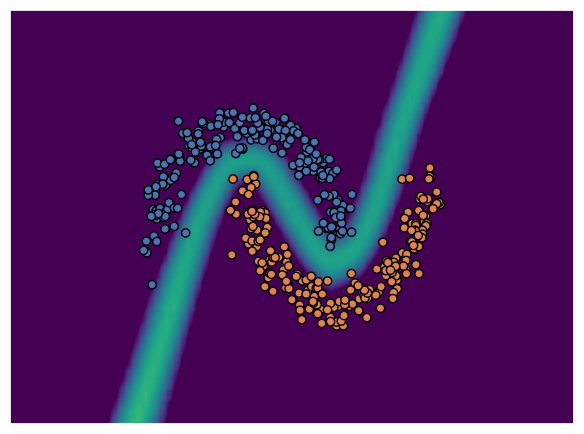

In [27]:
plot_single_uncertainty(yy, x, x_test, epistemic_b, (-2, 1), "laplace_setting_b_epistemic_uncertainty", log=True, ref_pred=reference_pred)
plot_single_uncertainty(yy, x, x_test, epistemic_a, (-2, -0.1), "laplace_setting_a_epistemic_uncertainty", log=True)

## SG-MCMC

In [30]:
T = int(1e5)
momentum = 0.9 # = 0 for SGLD, != 0 for SGHMC
sgld_lr = 1e-3

beta = 1/4
n_cycles = 5 # set to zero to use ABScheduler

final_lr = 1e-4
gamma = 0.55
burn = 0

In [32]:
fix_seeds(global_seed)

x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.long).flatten()
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32)

network = nn.Sequential(nn.Linear(len(x_labels), hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, n_classes))

network.to(device)
network.train()

sgmcmc = SGLD(network.parameters(), lr=sgld_lr, momentum=momentum, weight_decay=weight_decay)
if n_cycles == 0:
    sgmcmc_scheduler = ABAnnealingLR(sgmcmc, final_lr=final_lr, T_max=T, gamma=gamma)
else:
    sgmcmc_scheduler = CosineLR(sgmcmc, n_cycles=n_cycles, n_samples=T, T_max=T, beta=beta)

samples = []
ce = nn.CrossEntropyLoss()
for t in tqdm(range(T)):
    sgmcmc.zero_grad()

    idx = torch.randperm(x_train.size(0))[:batch_size]
    pred = network.forward(x_train[idx])

    loss = ce(pred, y_train[idx])

    loss.backward()

    if n_cycles != 0 and sgmcmc_scheduler.get_last_beta() <= sgmcmc_scheduler.beta:
        sgmcmc.step(noise=False)
    else:
        sgmcmc.step()

        if n_cycles != 0 or t >= burn:
            with torch.no_grad():
                samples.append(torch.softmax(network(x_test), dim=-1).detach().cpu())

    sgmcmc_scheduler.step()

samples = torch.stack(samples).squeeze(1)

100%|██████████| 100000/100000 [05:24<00:00, 308.46it/s]


In [33]:
yy = y_train.cpu().numpy()
x = x_train.cpu().numpy()
x_test = x_test.cpu().numpy()
samples = samples.cpu().numpy()
print(samples.shape)

(74995, 6400, 2)


(2, 3)


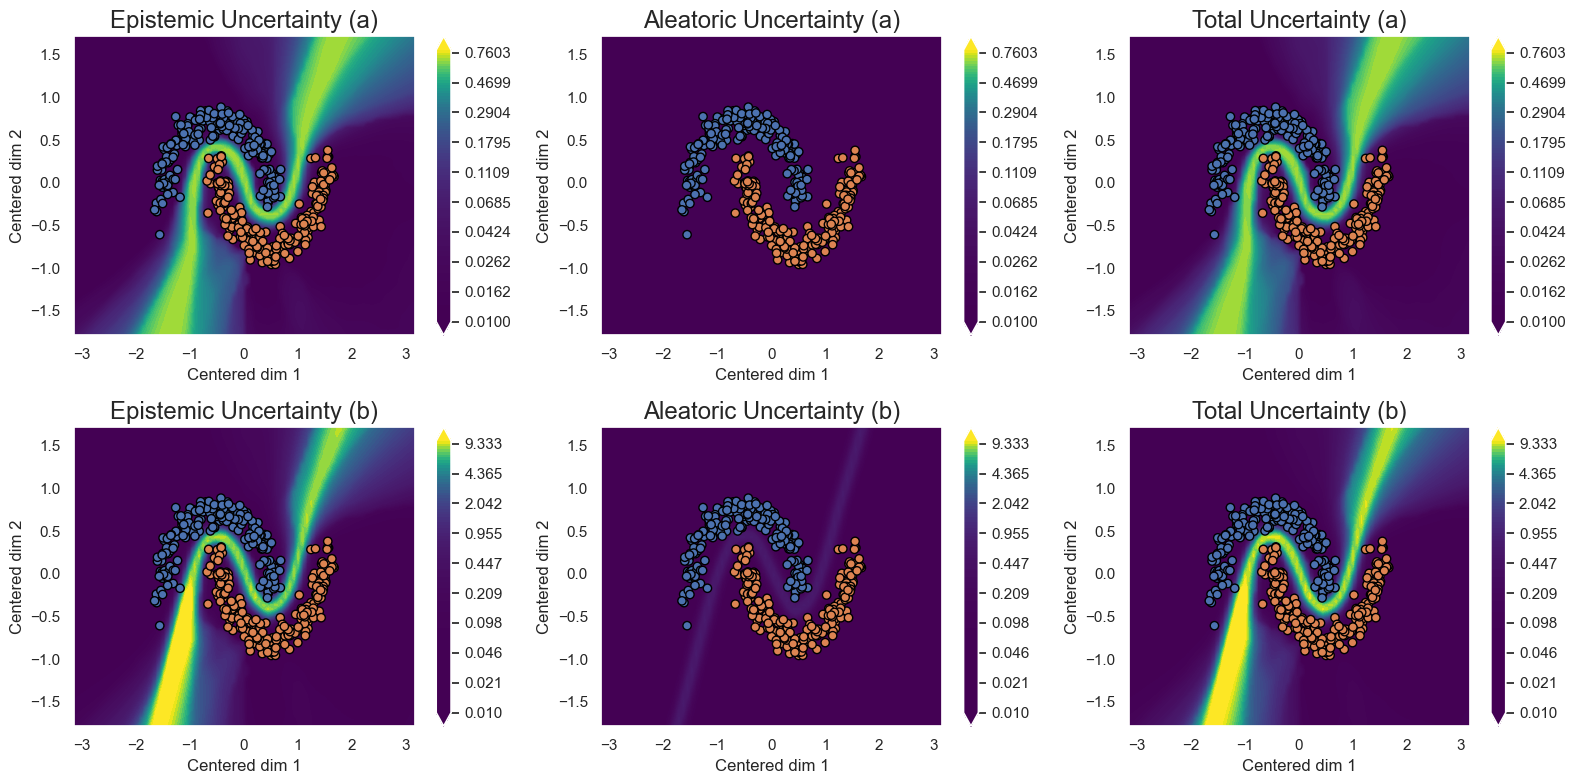

In [34]:
total_a = - np.sum(np.mean(samples, axis=0) * np.log(np.mean(samples, axis=0) + 1e-8), axis=-1)
aleatoric_a = np.mean( - np.sum(samples * np.log(samples + 1e-8), axis=-1), axis=0)
epistemic_a = total_a - aleatoric_a

total_b = - np.mean(np.sum(reference_pred[np.newaxis] * np.log(samples + 1e-8), axis=-1), axis=0)
aleatoric_b = - np.sum(reference_pred * np.log(reference_pred + 1e-8), axis=-1)
epistemic_b = total_b - aleatoric_b

uncertainties = [epistemic_a, aleatoric_a, total_a, epistemic_b, aleatoric_b, total_b]
titles = ["Epistemic Uncertainty (a)", "Aleatoric Uncertainty (a)", "Total Uncertainty (a)", "Epistemic Uncertainty (b)", "Aleatoric Uncertainty (b)", "Total Uncertainty (b)"]
minmaxes = [(-2, -0.1), (-2, -0.1), (-2, -0.1), (-2, 1), (-2, 1), (-2, 1)]

plot_uncertainty(yy, x, x_test, uncertainties, minmaxes, titles, "class_sgmcmc_uncertainty")

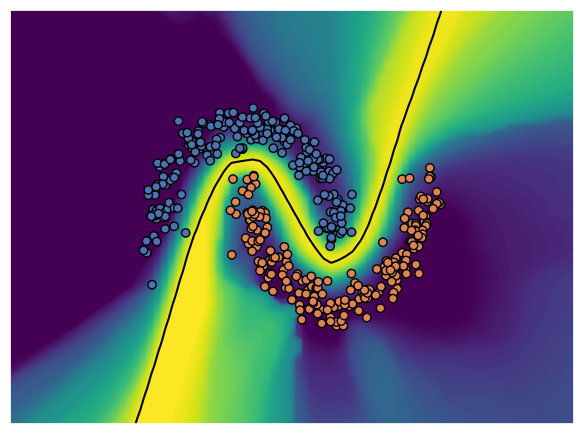

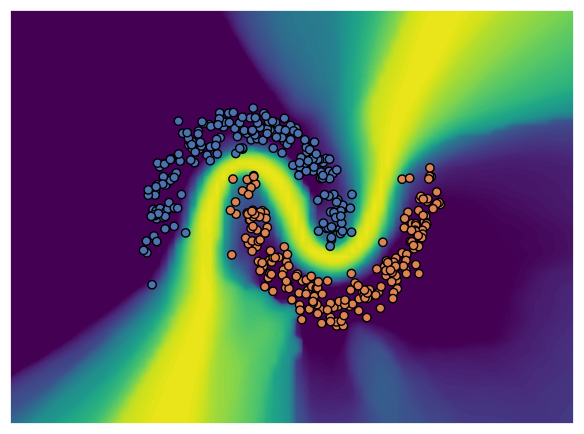

In [35]:
plot_single_uncertainty(yy, x, x_test, epistemic_b, (-2, 1), "sgmcmc_setting_b_epistemic_uncertainty", log=True, ref_pred=reference_pred) 
plot_single_uncertainty(yy, x, x_test, epistemic_a, (-2, -0.1), "sgmcmc_setting_a_epistemic_uncertainty", log=True) 

## Ensemble Methods

In [36]:
# parameters
n_ensemble = 20

100%|██████████| 1000/1000 [00:03<00:00, 285.27it/s]


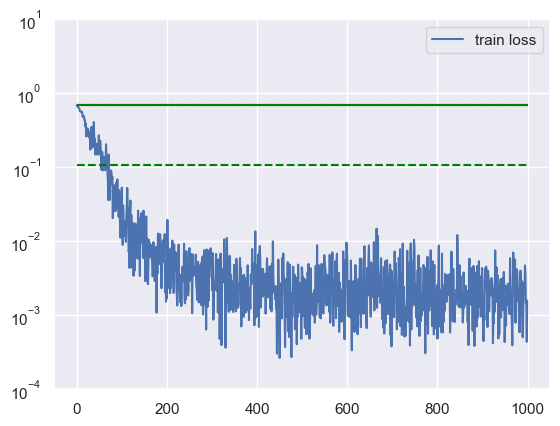

100%|██████████| 1000/1000 [00:03<00:00, 298.25it/s]


In [37]:
fix_seeds(global_seed)

pred_test = list()

x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.long).flatten()
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32)

for e in range(n_ensemble):
    network = nn.Sequential(nn.Linear(len(x_labels), hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, hidden_size),
                            nn.ReLU(),
                            nn.Linear(hidden_size, n_classes))
    network.to(device)
    network.train()

    opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

    losses = list()

    fit(network, opt, x_train, y_train, iterations, batch_size, plot=(e == 0))

    with torch.no_grad():
        network.eval()
        preds = torch.softmax(network.forward(x_test), dim=1).cpu().numpy()
    pred_test.append(preds)

pred_test = np.asarray(pred_test)

In [38]:
print(pred_test.shape)

yy = y_train.cpu().numpy()
x = x_train.cpu().numpy()
x_test = x_test.cpu().numpy()

(20, 6400, 2)


(2, 3)


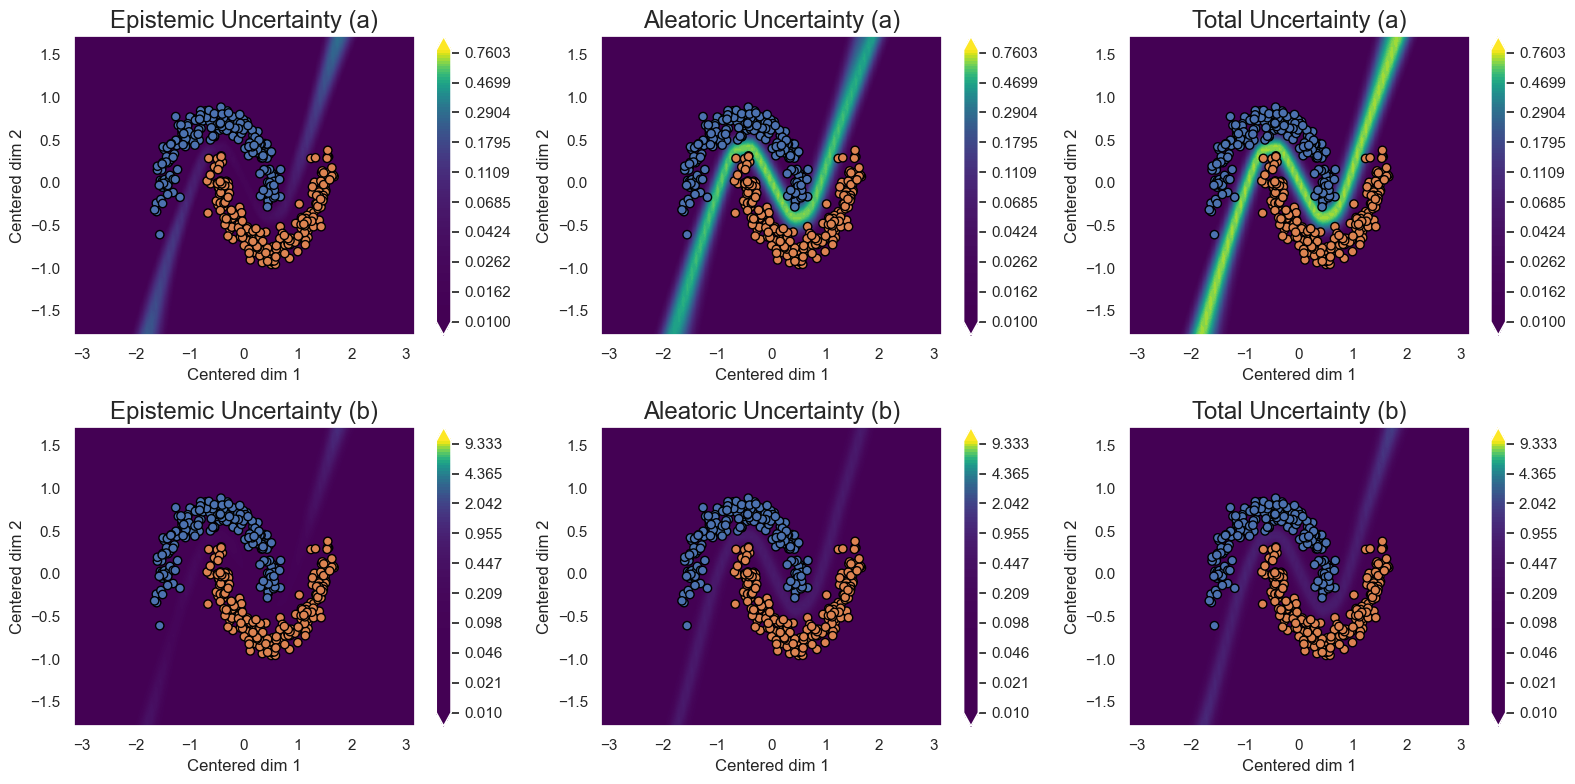

In [39]:
total_a = - np.sum(np.mean(pred_test, axis=0) * np.log(np.mean(pred_test, axis=0)), axis=-1)
aleatoric_a = np.mean( - np.sum(pred_test * np.log(pred_test), axis=-1), axis=0)
epistemic_a = total_a - aleatoric_a

total_b = - np.mean(np.sum(reference_pred[np.newaxis] * np.log(pred_test + 1e-8), axis=-1), axis=0)
aleatoric_b = - np.sum(reference_pred * np.log(reference_pred + 1e-8), axis=-1)
epistemic_b = total_b - aleatoric_b

uncertainties = [epistemic_a, aleatoric_a, total_a, epistemic_b, aleatoric_b, total_b]
titles = ["Epistemic Uncertainty (a)", "Aleatoric Uncertainty (a)", "Total Uncertainty (a)", "Epistemic Uncertainty (b)", "Aleatoric Uncertainty (b)", "Total Uncertainty (b)"]
minmaxes = [(-2, -0.1), (-2, -0.1), (-2, -0.1), (-2, 1), (-2, 1), (-2, 1)]

plot_uncertainty(yy, x, x_test, uncertainties, minmaxes, titles, "class_ensemble_uncertainty")

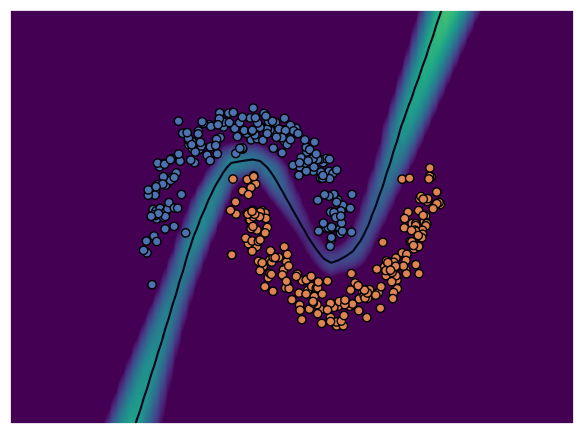

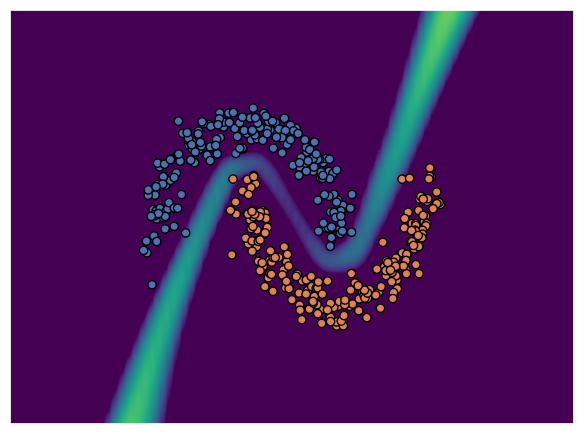

In [40]:
plot_single_uncertainty(yy, x, x_test, epistemic_b, (-2, 1), "ensemble_setting_b_epistemic_uncertainty", log=True, ref_pred=reference_pred)
plot_single_uncertainty(yy, x, x_test, epistemic_a, (-2, -0.1), "ensemble_setting_a_epistemic_uncertainty", log=True)

## MC-Dropout

In [41]:
# parameters
dropout_rate = 0.2
forward_passes = 10_000

100%|██████████| 1000/1000 [00:03<00:00, 267.32it/s]


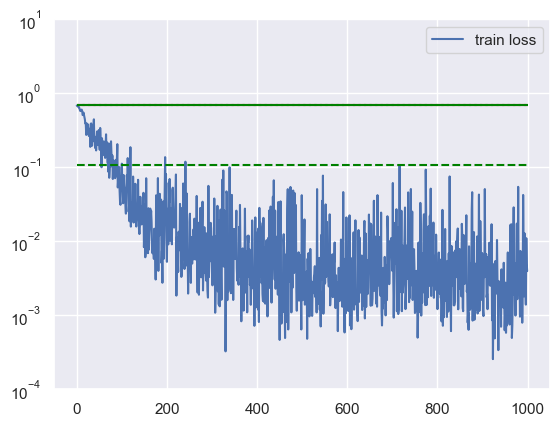

inference: 100%|██████████| 10000/10000 [00:12<00:00, 813.96it/s]


In [42]:
fix_seeds(global_seed)

pred_test = list()

x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.long).flatten()
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32)

ce = nn.CrossEntropyLoss()

network = nn.Sequential(nn.Linear(len(x_labels), hidden_size),
                        nn.Dropout(p=dropout_rate),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.Dropout(p=dropout_rate),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.Dropout(p=dropout_rate),
                        nn.ReLU(),
                        nn.Linear(hidden_size, n_classes))
network.to(device)
network.train()

opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

fit(network, opt, x_train, y_train, iterations, batch_size)

with torch.no_grad():
    network.eval()
    mcd_reference_pred = torch.softmax(network.forward(x_test), dim=1).detach().cpu().numpy()
    
    network.train()
    for _ in tqdm(range(forward_passes), desc="inference"):
        preds = torch.softmax(network.forward(x_test), dim=1).detach().cpu().numpy()
        pred_test.append(preds)

pred_test = np.asarray(pred_test)

In [43]:
yy = y_train.cpu().numpy()
x = x_train.cpu().numpy()
x_test = x_test.cpu().numpy()

(2, 3)


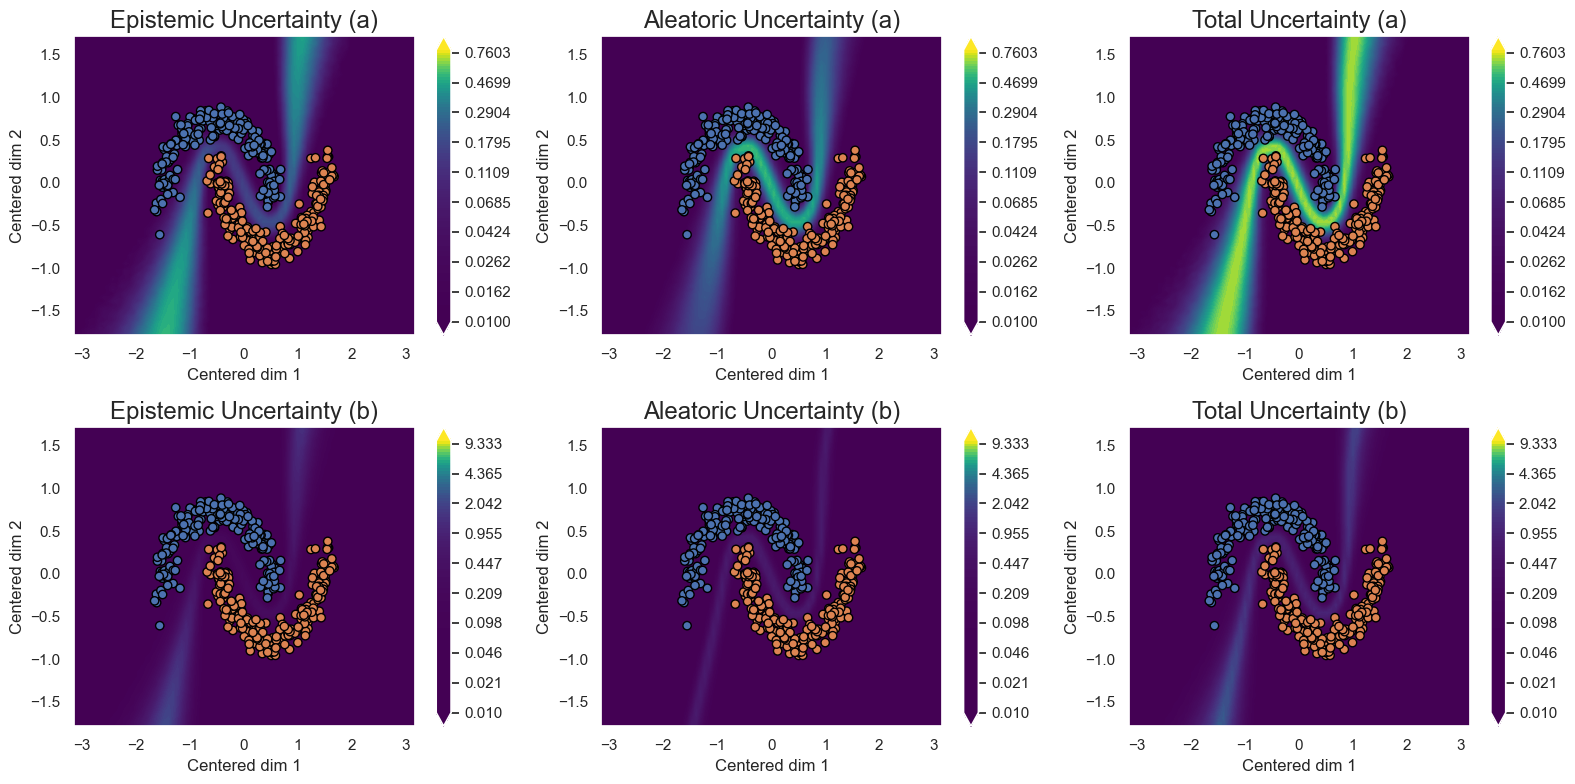

In [44]:
total_a = - np.sum(np.mean(pred_test, axis=0) * np.log(np.mean(pred_test, axis=0) + 1e-8), axis=-1)
aleatoric_a = np.mean( - np.sum(pred_test * np.log(pred_test + 1e-8), axis=-1), axis=0)
epistemic_a = total_a - aleatoric_a

total_b = - np.mean(np.sum(mcd_reference_pred[np.newaxis] * np.log(pred_test + 1e-8), axis=-1), axis=0)
aleatoric_b = - np.sum(mcd_reference_pred * np.log(mcd_reference_pred + 1e-8), axis=-1)
epistemic_b = total_b - aleatoric_b

uncertainties = [epistemic_a, aleatoric_a, total_a, epistemic_b, aleatoric_b, total_b]
titles = ["Epistemic Uncertainty (a)", "Aleatoric Uncertainty (a)", "Total Uncertainty (a)", "Epistemic Uncertainty (b)", "Aleatoric Uncertainty (b)", "Total Uncertainty (b)"]
minmaxes = [(-2, -0.1), (-2, -0.1), (-2, -0.1), (-2, 1), (-2, 1), (-2, 1)]

plot_uncertainty(yy, x, x_test, uncertainties, minmaxes, titles, "class_mc_dropout_uncertainty")

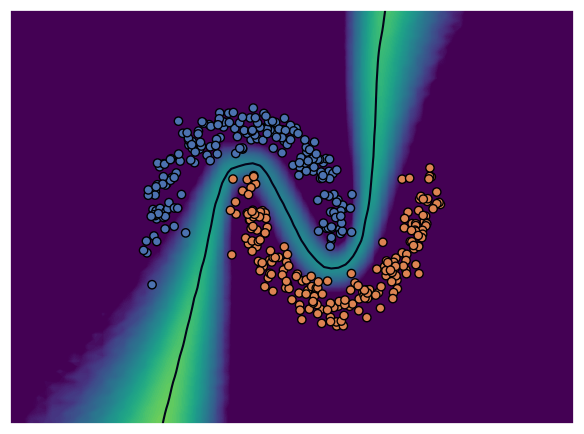

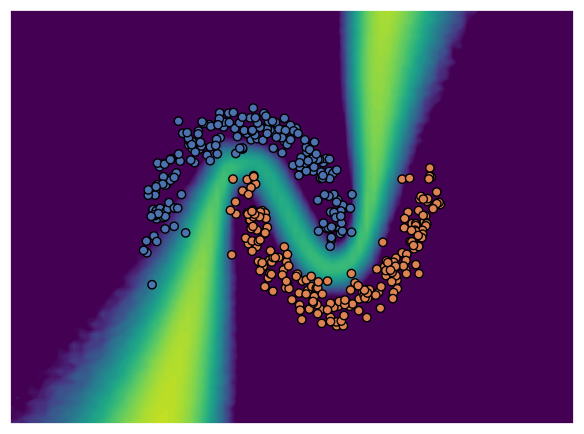

In [45]:
plot_single_uncertainty(yy, x, x_test, epistemic_b, (-2, 1), "mcdropout_setting_b_epistemic_uncertainty", log=True, ref_pred = mcd_reference_pred)
plot_single_uncertainty(yy, x, x_test, epistemic_a, (-2, -0.1), "mcdropout_setting_a_epistemic_uncertainty", log=True)

## QUAM

In [52]:
adversaries = 5
optim_steps = 15
adv_iterations = 10
lr_adv = 1e-3
gamma = 0
c_0 = 1e-0
eta = 3

In [ ]:
fix_seeds(global_seed)

x_train = torch.as_tensor(x_train).to(device=device, dtype=torch.float32)
y_train = torch.as_tensor(y_train).to(device=device, dtype=torch.long).flatten()
x_test = torch.as_tensor(x_test).to(device=device, dtype=torch.float32)

ce = nn.CrossEntropyLoss()

network = nn.Sequential(nn.Linear(len(x_labels), hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, n_classes))
network.to(device)
network.train()

opt = optim.Adam(params=network.parameters(), lr=lr, weight_decay=weight_decay)

fit(network, opt, x_train, y_train, iterations, batch_size)

# predictions with original network
with torch.no_grad():
    test_net_pred = torch.softmax(network.forward(x_test), dim=1).cpu().numpy().reshape(1, -1, n_classes)
    train_net_pred = network.forward(x_train)
    train_net_ce = ce(train_net_pred, y_train)

all_losses = list()
pred_test = list()
g_cpu = torch.Generator(device="cpu")

# Adversarial Attack
for a, l in product(range(adversaries), range(n_classes)):
    
    y_test = torch.LongTensor([l]).to(device=device)

    for i in tqdm(range(len(x_test)), desc=f"inference {a * n_classes + l + 1} / {adversaries * n_classes}"):

        adversarial_network = copy.deepcopy(network)
        adversarial_network.train()

        opt = optim.Adam(params=adversarial_network.parameters(), lr=lr_adv, weight_decay=weight_decay)
        preds, losses = list(), list()

        c = c_0
        for ad_i in range(adv_iterations):
            for op_s in range(optim_steps):
                idx = torch.randperm(x_train.size(0))[:batch_size]
                train_adv_pred = adversarial_network.forward(x_train[idx])
                penalty = ce(train_adv_pred, y_train[idx])
                
                test_adv_pred = adversarial_network.forward(x_test[i].reshape(1, -1))
                objective = ce(test_adv_pred, y_test)

                loss = objective + c * (penalty - train_net_ce - gamma)

                losses.append((objective.item(), penalty.item()))
                
                with torch.no_grad():
                    adversarial_network.eval()
                    preds.append(torch.softmax(adversarial_network.forward(x_test[i].reshape(1, -1)), dim=1).cpu().numpy())
                    adversarial_network.train()

                opt.zero_grad()
                loss.backward()
                opt.step()
            
            # update parameter
            c *= eta
        
        all_losses.append(losses)
        pred_test.append(preds)


In [ ]:
with open(os.path.join("results_two_moon", "preds_quam.pkl"),"wb") as f:
    pickle.dump(pred_test, f)
with open(os.path.join("results_two_moon", "losses_quam.pkl"),"wb") as f:
    pickle.dump(all_losses, f)

In [54]:
with open(os.path.join("results_two_moon", "preds_quam.pkl"),"rb") as f:
    pred_test = pickle.load(f)
with open(os.path.join("results_two_moon", "losses_quam.pkl"),"rb") as f:
    all_losses = pickle.load(f)

In [55]:
def softmax(x, axis=-1):
    return np.exp(x) / np.exp(x).sum(axis=axis, keepdims=True)

In [56]:
temperature = 1e-2

log_likelihoods = -np.asarray(all_losses)[..., 1]
print(log_likelihoods.shape)
log_likelihoods = log_likelihoods.reshape(adversaries, n_classes, -1, adv_iterations * optim_steps)
print(log_likelihoods.shape)
log_likelihoods = np.moveaxis(log_likelihoods, 3, 1).reshape(adversaries, adv_iterations * optim_steps * n_classes, -1, 1)
print(log_likelihoods.shape)
print("-"  *30)

print(np.asarray(pred_test).shape)
pred_test_ = np.asarray(pred_test).reshape(adversaries, n_classes, -1, adv_iterations * optim_steps, n_classes)
print(pred_test_.shape)
pred_test_ = np.moveaxis(pred_test_, 3, 1).reshape(adversaries, adv_iterations * optim_steps * n_classes, -1, n_classes)
print(pred_test_.shape)
print("-"  *30)

print(pred_test_.shape, log_likelihoods.shape)
pred_test__ = np.mean(np.sum(pred_test_ * softmax(log_likelihoods / temperature, axis=1), axis=1, keepdims=True), axis=0)
print(pred_test_.shape, x_train.shape, y_train.shape, x_test.shape)
print(pred_test__.shape)

print(np.min(pred_test__), np.max(pred_test__))

(64000, 150)
(5, 2, 6400, 150)
(5, 300, 6400, 1)
------------------------------
(64000, 150, 1, 2)
(5, 2, 6400, 150, 2)
(5, 300, 6400, 2)
------------------------------
(5, 300, 6400, 2) (5, 300, 6400, 1)
(5, 300, 6400, 2) torch.Size([400, 2]) torch.Size([400]) torch.Size([6400, 2])
(1, 6400, 2)
0.0009432021894676925 0.9990567977587548


In [57]:

pred_test = np.asarray(pred_test).reshape(adversaries, adv_iterations * optim_steps * n_classes, -1, 1, n_classes)
pred_test = np.moveaxis(pred_test, 3, 1).reshape(adversaries, adv_iterations * optim_steps * n_classes, -1, n_classes)


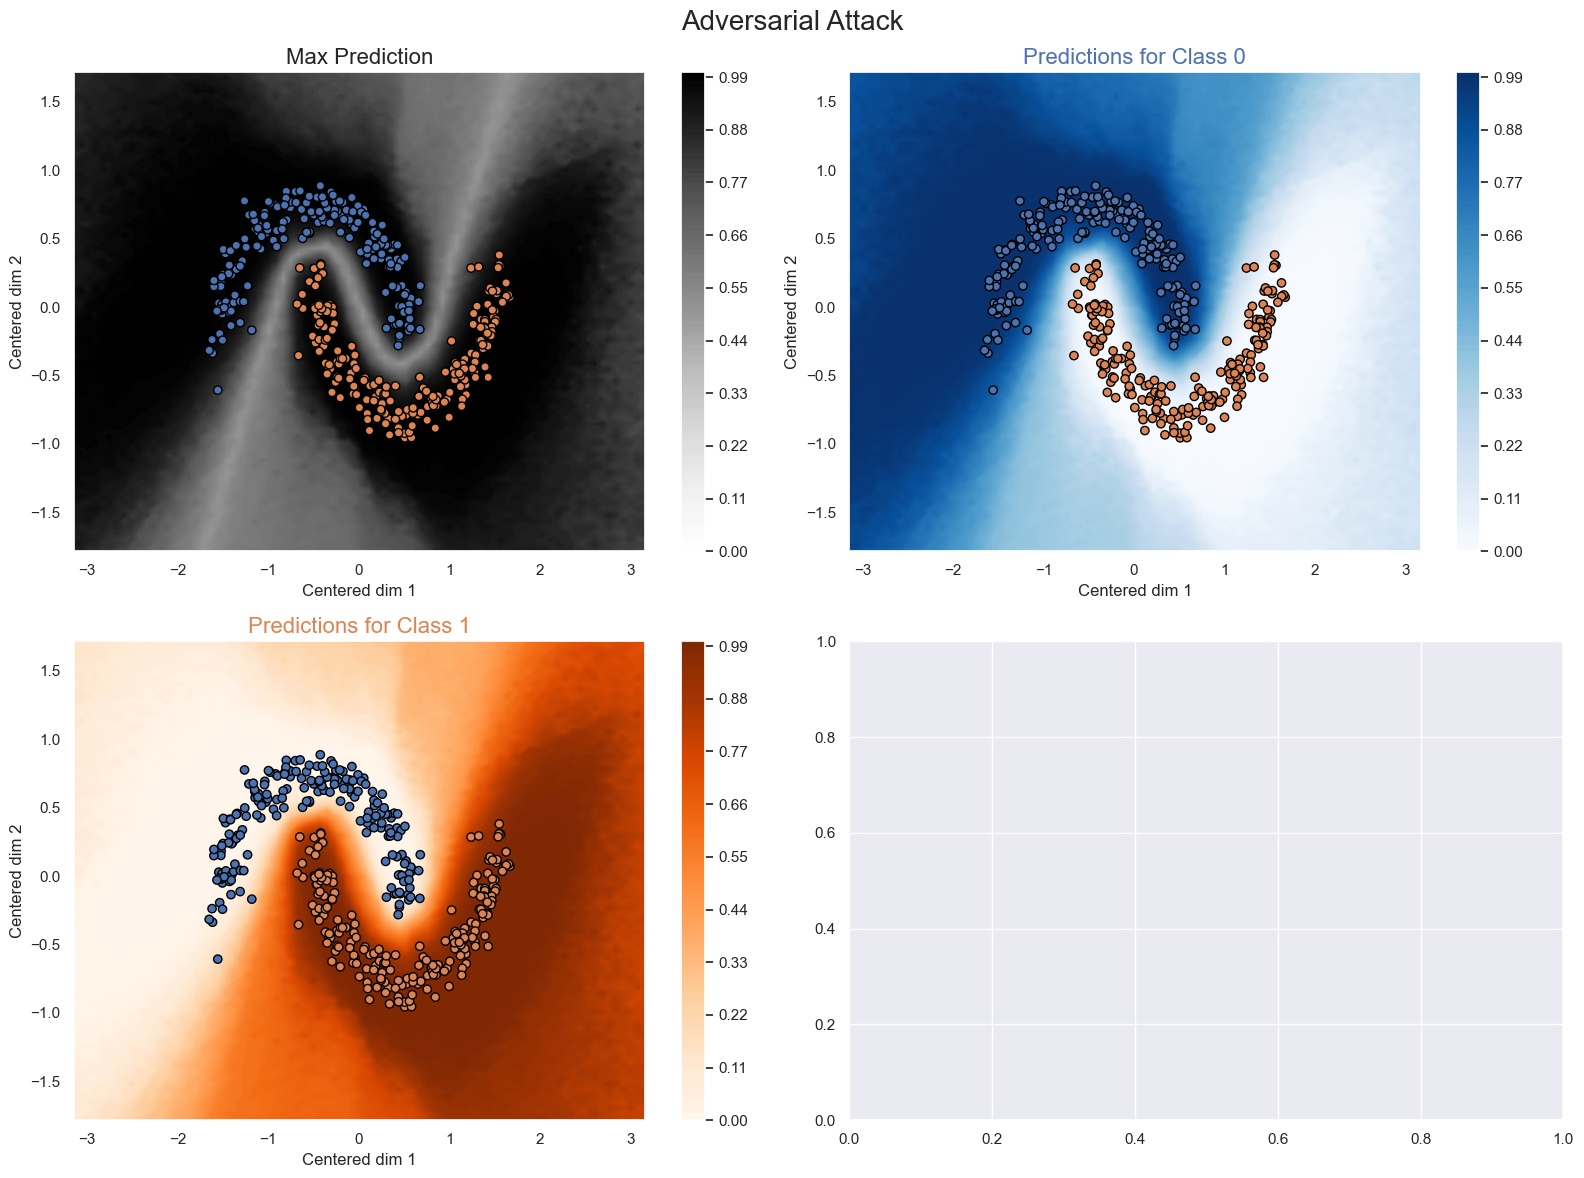

In [58]:
visualize(pred_test__, x_train, y_train, x_test, "Adversarial Attack", "class_adversarial_attack_classes.pdf")

In [59]:
yy = y_train.cpu().numpy()
x = x_train.cpu().numpy()
x_test = x_test.cpu().numpy()

(2, 3)


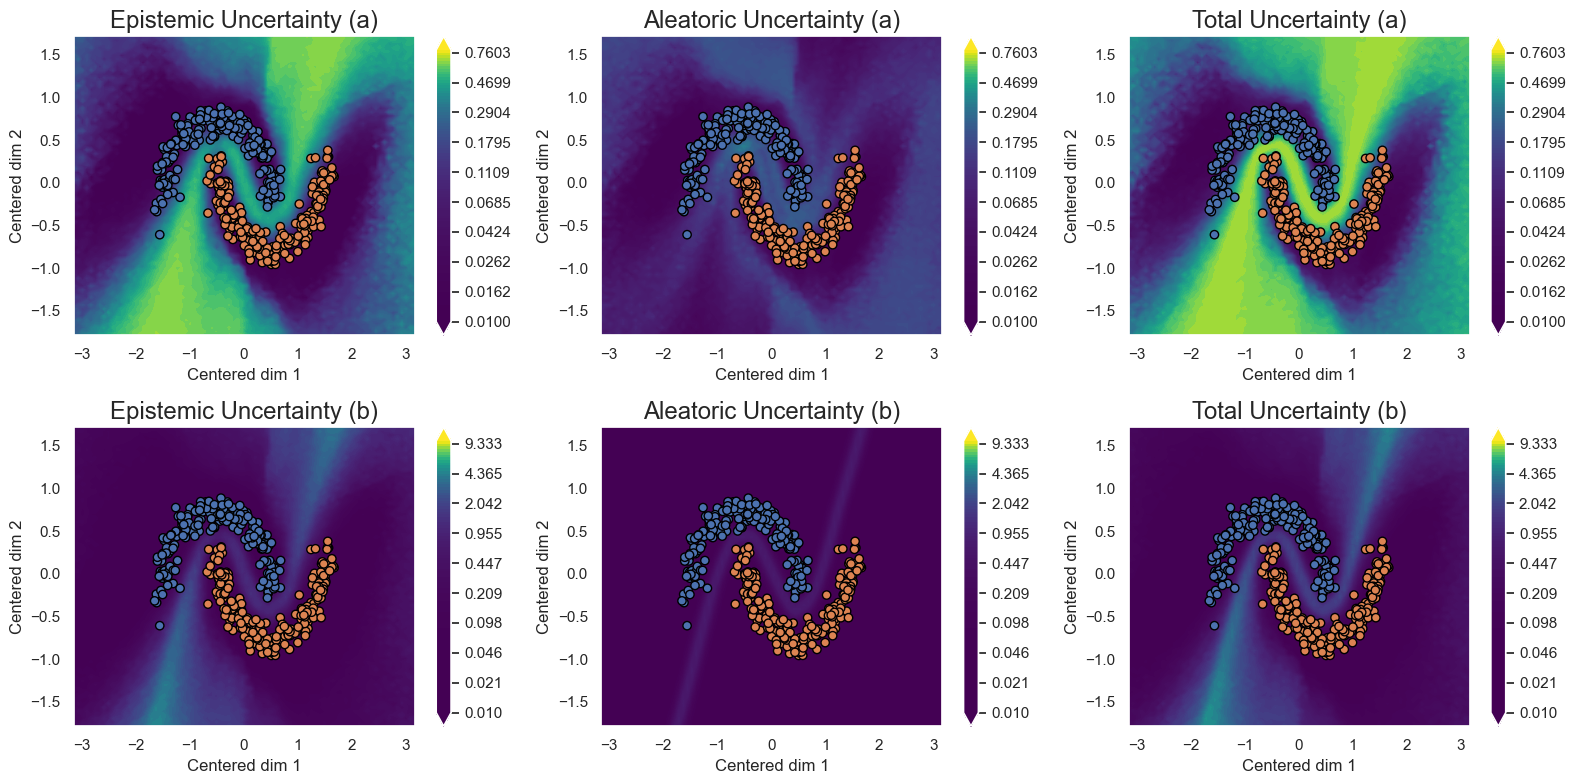

In [60]:
total_a = - np.sum(np.mean(pred_test__, axis=0) * np.log(np.mean(pred_test__, axis=0) + 1e-8), axis=-1)
aleatoric_a = np.mean(np.sum( - np.sum(pred_test_ * np.log(pred_test_ + 1e-8), axis=-1) * softmax(log_likelihoods[..., 0] / temperature, axis=1), axis=1), axis=0)
epistemic_a = total_a - aleatoric_a

total_b = - np.sum(np.mean(np.sum(reference_pred[np.newaxis] * np.log(pred_test_ + 1e-8), axis=-1) * softmax(log_likelihoods[..., 0] / temperature, axis=1), axis=0), axis=0)
aleatoric_b = - np.sum(reference_pred * np.log(reference_pred + 1e-8), axis=-1)
epistemic_b = total_b - aleatoric_b

uncertainties = [epistemic_a, aleatoric_a, total_a, epistemic_b, aleatoric_b, total_b]
titles = ["Epistemic Uncertainty (a)", "Aleatoric Uncertainty (a)", "Total Uncertainty (a)", "Epistemic Uncertainty (b)", "Aleatoric Uncertainty (b)", "Total Uncertainty (b)"]
minmaxes = [(-2, -0.1), (-2, -0.1), (-2, -0.1), (-2, 1), (-2, 1), (-2, 1)]

plot_uncertainty(yy, x, x_test, uncertainties, minmaxes, titles, "class_adversarial_uncertainty")

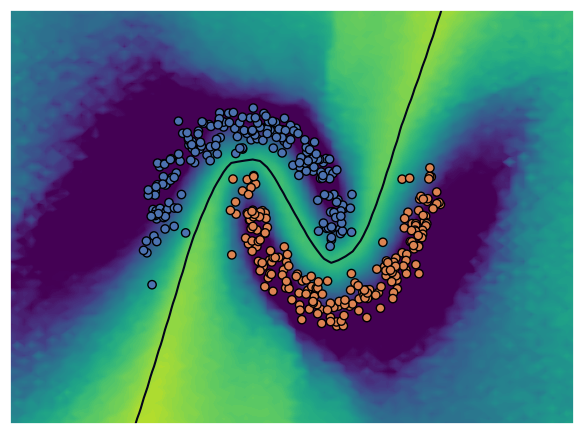

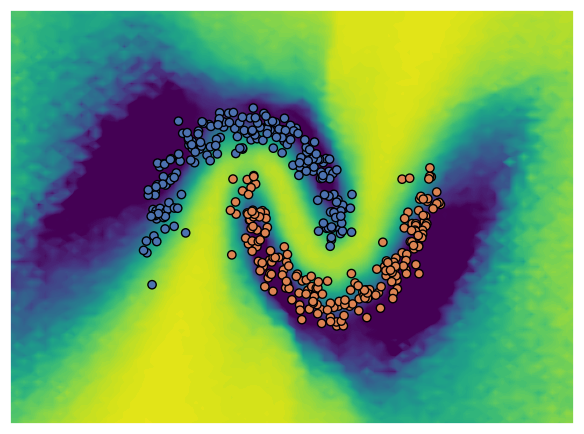

In [61]:
plot_single_uncertainty(yy, x, x_test, epistemic_b, (-2, 1), "quam_setting_b_epistemic_uncertainty", log=True, ref_pred=reference_pred)
plot_single_uncertainty(yy, x, x_test, epistemic_a, (-2, -0.1), "quam_setting_a_epistemic_uncertainty", log=True)